In [59]:
import torch
import torch.nn as nn
from torch.autograd import Variable
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import numpy as np

print('current device used:',device)

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden_layer1 = nn.Linear(2,5) #input num:2 for x,t
        self.hidden_layer2 = nn.Linear(5,5)
        self.hidden_layer3 = nn.Linear(5,5)
        self.hidden_layer4 = nn.Linear(5,5)
        self.hidden_layer5 = nn.Linear(5,5)
        self.output_layer = nn.Linear(5,1)

    def forward(self, x,t):
        inputs = torch.cat([x,t],axis=1) # combined two arrays of 1 columns each to one array of 2 columns
        layer1_out = torch.sigmoid(self.hidden_layer1(inputs))
        layer2_out = torch.sigmoid(self.hidden_layer2(layer1_out))
        layer3_out = torch.sigmoid(self.hidden_layer3(layer2_out))
        layer4_out = torch.sigmoid(self.hidden_layer4(layer3_out))
        layer5_out = torch.sigmoid(self.hidden_layer5(layer4_out))
        output = self.output_layer(layer5_out)
        return output

net = Net()
net = net.to(device)
mse_cost_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters())

current device used: cpu


In [60]:
def f(x,t, net):
    u = net(x,t)
    u_x = torch.autograd.grad(u.sum(), x, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_t = torch.autograd.grad(u.sum(), t, create_graph=True)[0]
    #pde = u_t - 0.01*u_xx-2*u*(1-u)
    pde = 1/40*u_t - 0.6*u - 5*u_xx
    #pde = u_x - 2*u_t - u #Exact solution's error(should be 0)
    return pde

In [61]:
x_bc = np.random.uniform(low=-0.5, high=0.5, size=(500,1))
t_bc = np.zeros((500,1))
ux_ic = 5*(np.cos(((np.pi/9)**1)*x_bc))
ut_ic = 0*t_bc
#u_bc = 6*np.exp(-3*x_bc) #BC when t=0

In [62]:
iterations = 20000
previous_validation_loss = 99999999.0
loss_count=[]
for epoch in range(iterations):
    optimizer.zero_grad()

    pt_x_bc = Variable(torch.from_numpy(x_bc).float(), requires_grad=False).to(device)
    pt_t_bc = Variable(torch.from_numpy(t_bc).float(), requires_grad=False).to(device)
    pt_ux_ic = Variable(torch.from_numpy(ux_ic).float(), requires_grad=False).to(device)

    net_bc_out = net(pt_x_bc, pt_t_bc)
    mse_u = mse_cost_function(net_bc_out, pt_ux_ic)

    x_collocation = np.random.uniform(low=-0.5, high=0.5, size=(500,1)) #Fixed range
    t_collocation = np.random.uniform(low=0.0, high=1.0, size=(500,1)) #Fixed range
    all_zeros = np.zeros((500,1))

    pt_x_collocation = Variable(torch.from_numpy(x_collocation).float(), requires_grad=True).to(device)
    pt_t_collocation = Variable(torch.from_numpy(t_collocation).float(), requires_grad=True).to(device)
    pt_all_zeros = Variable(torch.from_numpy(all_zeros).float(), requires_grad=False).to(device)

    f_out = f(pt_x_collocation, pt_t_collocation, net)
    mse_f = mse_cost_function(f_out, pt_all_zeros)

    loss = mse_u + mse_f

    loss.backward()
    optimizer.step()

    with torch.autograd.no_grad():
        loss_count.append(loss.item())
        if epoch % 1000 == 0:
    	    print(epoch,"Traning Loss:",loss.item())


0 Traning Loss: 28.02724266052246
1000 Traning Loss: 6.946246147155762
2000 Traning Loss: 0.5006086826324463
3000 Traning Loss: 0.05371224880218506
4000 Traning Loss: 0.03048510104417801
5000 Traning Loss: 0.02399299666285515
6000 Traning Loss: 0.020276861265301704
7000 Traning Loss: 0.01882324554026127
8000 Traning Loss: 0.019222943112254143
9000 Traning Loss: 0.018104828894138336
10000 Traning Loss: 0.020083069801330566
11000 Traning Loss: 0.017231298610568047
12000 Traning Loss: 0.017626959830522537
13000 Traning Loss: 0.017299357801675797
14000 Traning Loss: 0.0162802767008543
15000 Traning Loss: 0.01512027345597744
16000 Traning Loss: 0.0009534572018310428
17000 Traning Loss: 0.0004488652048166841
18000 Traning Loss: 0.0002023506531259045
19000 Traning Loss: 0.00011662058386718854


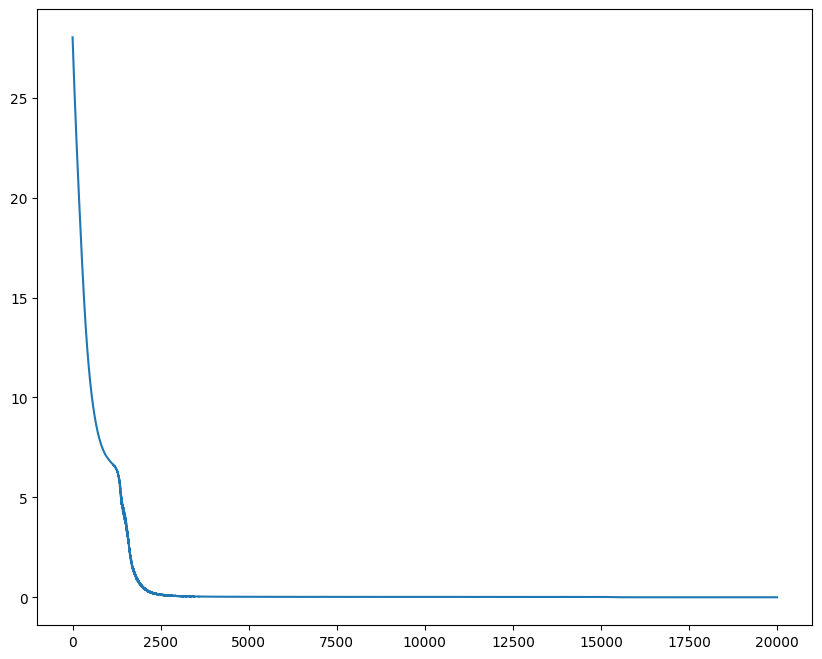

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.plot(loss_count)
plt.show()

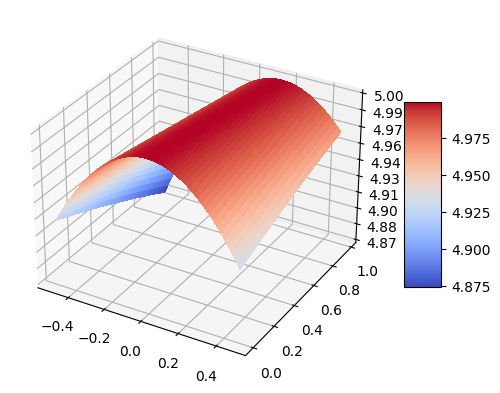

In [64]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')  # Use add_subplot to create a 3D axes

x=np.arange(-0.5,0.5,0.02)
t=np.arange(0,1,0.02)
ms_x, ms_t = np.meshgrid(x, t)
## Just because meshgrid is used, we need to do the following adjustment
x = np.ravel(ms_x).reshape(-1,1)
t = np.ravel(ms_t).reshape(-1,1)

pt_x = Variable(torch.from_numpy(x).float(), requires_grad=True).to(device)
pt_t = Variable(torch.from_numpy(t).float(), requires_grad=True).to(device)
pt_u = net(pt_x,pt_t)
u=pt_u.data.cpu().numpy()
ms_u = u.reshape(ms_x.shape)

surf = ax.plot_surface(ms_x,ms_t,ms_u, cmap=cm.coolwarm,linewidth=0, antialiased=False)



ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

[-5.0000000e-01 -4.8000000e-01 -4.6000000e-01 -4.4000000e-01
 -4.2000000e-01 -4.0000000e-01 -3.8000000e-01 -3.6000000e-01
 -3.4000000e-01 -3.2000000e-01 -3.0000000e-01 -2.8000000e-01
 -2.6000000e-01 -2.4000000e-01 -2.2000000e-01 -2.0000000e-01
 -1.8000000e-01 -1.6000000e-01 -1.4000000e-01 -1.2000000e-01
 -1.0000000e-01 -8.0000000e-02 -6.0000000e-02 -4.0000000e-02
 -2.0000000e-02  4.4408921e-16  2.0000000e-02  4.0000000e-02
  6.0000000e-02  8.0000000e-02  1.0000000e-01  1.2000000e-01
  1.4000000e-01  1.6000000e-01  1.8000000e-01  2.0000000e-01
  2.2000000e-01  2.4000000e-01  2.6000000e-01  2.8000000e-01
  3.0000000e-01  3.2000000e-01  3.4000000e-01  3.6000000e-01
  3.8000000e-01  4.0000000e-01  4.2000000e-01  4.4000000e-01
  4.6000000e-01  4.8000000e-01]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[4.8986783 4.9054904 4.912066  4.918405  4.9245067 4.930371  4.9359975
 4.941386  

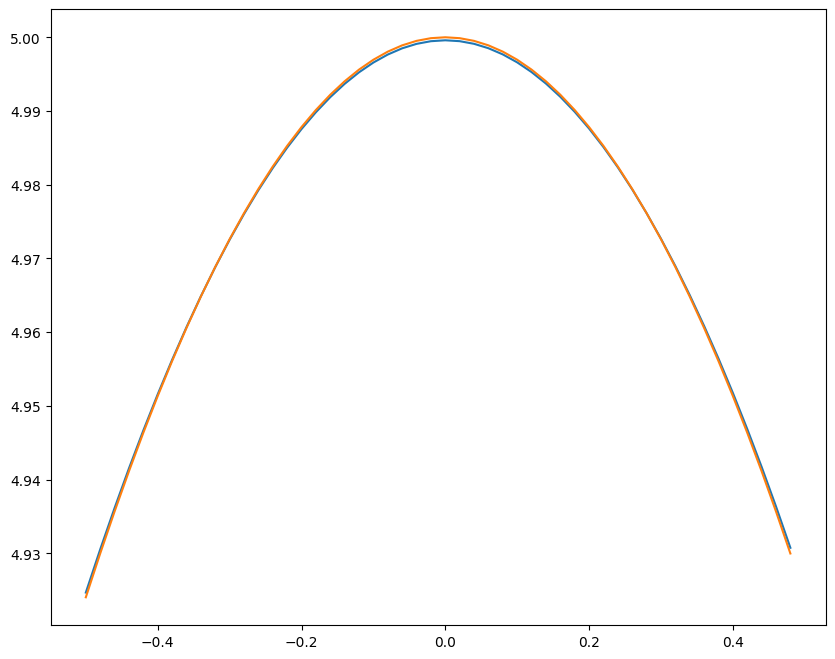

In [65]:
print(ms_x[25])
print(ms_t[0])
print(ms_u[25])

ms_u_x25 = [ms_u[i][25] for i in range(len(ms_u))]
y1 = ux_ic = 5*(np.cos(((np.pi/9)**1)*ms_x[0]))
plt.figure(figsize=(10,8))
plt.plot(ms_x[0],ms_u[0])
plt.plot(ms_x[0],y1)
plt.show()